In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from cluster_analysis import C_HDBSCAN, C_GaussianMixture, ClusterEvalIoU
from recurse_cluster import RecursiveCluster

In [3]:
cluster1 = C_HDBSCAN(metric='euclidean', min_cluster_size=200, min_samples=20)
cluster1.config()

In [4]:
df = pd.read_hdf('./data/m12i_cluster_data_large_mass_large_cluster.h5', key='star')
cluster1.add_data(df, columns=['feH', 'mgfe'])
df.head()

,Unnamed: 0,feH,id_stars,radial_distance_stars,redshift_stars,snap_list_stars,star_mass,subhalo_mass_stars,subhalo_peak_mass,subhalo_stellar_mass_stars,...,vrstar,vthetastar,vxstar,vystar,vzstar,xstar,ystar,zstar,cluster_id,mgfe
29707,29707,-2.018454,838243,12.432716,3.324324,108,4815.091839,1.505128e+09,1.908832e+09,2658320.0,...,-138.206238,-93.673630,154.327881,-77.277222,-64.244301,-4.066947,5.468583,10.398412,1,0.423883
29753,29753,-3.158415,3625199,13.983459,3.324324,108,4794.496221,1.505128e+09,1.908832e+09,2658320.0,...,134.368500,73.260727,46.631748,-146.044968,5.821562,4.447518,-11.160137,7.155980,1,-0.298731
29761,29761,-2.264334,4019904,11.334940,3.324324,108,5051.988002,1.505128e+09,1.908832e+09,2658320.0,...,164.856873,-6.858140,111.658516,121.620918,4.364055,8.027174,8.000997,-0.171431,1,0.449560
29778,29778,-2.191123,4851085,3.942200,3.324324,108,4586.961061,1.505128e+09,1.908832e+09,2658320.0,...,48.959938,-186.282364,339.985504,-48.394810,162.768936,-0.436346,2.650589,2.885293,1,0.449493
29802,29802,-2.827400,6162665,9.129913,3.324324,108,4407.890121,1.505128e+09,1.908832e+09,2658320.0,...,155.343323,368.343475,-51.868664,236.764603,-319.613495,0.362122,-4.580537,-7.889415,1,-0.476571


In [4]:
labels = cluster1.fit()

In [5]:
eval_IoU1 = ClusterEvalIoU(labels, df['cluster_id'].to_numpy())
print(eval_IoU1())
print(eval_IoU1.TP)
print(eval_IoU1.T)
print(eval_IoU1.P)
# IoU metric makes no sense when the cutoff is below 0.5

(7.333333333333333, 0.44)
22
50
3


In [6]:
print(labels)
label_names = np.array([f'cluster {label}' for label in labels])
labels_sorted = np.sort(labels)
print(labels_sorted)

[ 0 -1  0 ...  0  0  0]
[-1 -1 -1 ...  1  1  1]


In [7]:
chosen_cluster_ids = np.random.choice(np.arange(1,50), 1)
chosen_ids = np.argwhere(df['cluster_id'].isin(chosen_cluster_ids).to_numpy())[:,0]

<AxesSubplot:xlabel='feH', ylabel='mgfe'>

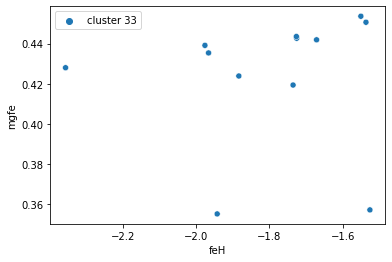

In [8]:
sns.scatterplot(data=df.iloc[chosen_ids], x='feH', y='mgfe', hue=np.array([f'cluster {id}' for id in df['cluster_id'].to_numpy()])[chosen_ids])

<AxesSubplot:xlabel='feH', ylabel='mgfe'>

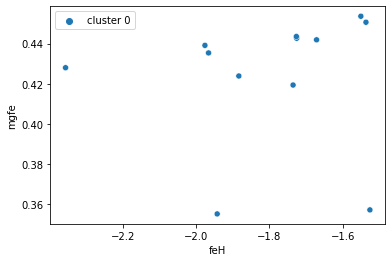

In [9]:
sns.scatterplot(data=df.iloc[chosen_ids], x='feH', y='mgfe', hue=label_names[chosen_ids])

In [10]:
from collections import Counter
print(len(chosen_ids))
Counter(label_names[chosen_ids]).most_common()

12


[('cluster 0', 12)]

In [8]:
from sklearn import metrics

In [12]:
metrics.rand_score(df['cluster_id'].to_numpy(), labels)

0.297233688970999

In [13]:
eval_IoU1 = ClusterEvalIoU(labels, df['cluster_id'].to_numpy())
print(eval_IoU1())
print(eval_IoU1.TP)

(7.333333333333333, 0.44)
22


In [14]:
print(eval_IoU1.P)

3


### Now let's test out recursive clustering

In [27]:
clustera = C_HDBSCAN(metric='euclidean', min_cluster_size=2, min_samples=1, allow_single_cluster=True)
clusterb = C_HDBSCAN(metric='euclidean', min_cluster_size=2, min_samples=1, allow_single_cluster=True)
cluster2 = RecursiveCluster(subspace1_clusterer=clustera, subspace2_clusterer=clusterb)
cluster2.config()

In [28]:
cluster2.add_data(df, subspace1=['feH','mgfe'], subspace2=['feH','mgfe'])

In [29]:
labels2 = cluster2.fit()

[0 0 0 ... 0 0 0]
[29429   166    -1 ... 34129 16868 37740]
44066
44066
[   -1   166    -1 ...    -1    -1 37740]
[   -1   166    -1 ...    -1    -1 37740]
44066
44066


In [18]:
print(labels2)
label2_names = np.array([f'cluster {label}' for label in labels2])
labels_sorted = np.sort(labels2)
print(labels_sorted)

[   -1    -1  7579 ... 43818    -1 48470]
[   -1    -1    -1 ... 51662 51663 51663]


In [19]:
chosen_ids = np.argwhere(df['cluster_id'].isin(chosen_cluster_ids).to_numpy())[:,0]

In [20]:
#sns.scatterplot(data=df.iloc[chosen_ids], x='feH', y='mgfe', hue=label2_names[chosen_ids])

In [21]:
metrics.rand_score(df['cluster_id'].to_numpy(), labels2)

0.7065505895246961

In [22]:
metrics.rand_score(labels, labels2)

0.1470609716211652

In [23]:
eval_IoU1 = ClusterEvalIoU(labels, df['cluster_id'].to_numpy())
print(eval_IoU1())

(7.333333333333333, 0.44)


In [24]:
eval_IoU2 = ClusterEvalIoU(labels2, df['cluster_id'].to_numpy())
print(eval_IoU2())

(1.9355463079454177e-05, 0.02)


In [25]:
eval_IoU3 = ClusterEvalIoU(labels, labels2)
print(eval_IoU3())

(71.33333333333333, 0.004142069099003194)


### Now let's test HDBSCAN + GMM

In [5]:
clustera = C_HDBSCAN(metric='euclidean', min_cluster_size=2, min_samples=1, allow_single_cluster=True)
clusterb = C_GaussianMixture(n_components=1)
cluster3 = RecursiveCluster(subspace1_clusterer=clustera, subspace2_clusterer=clusterb)
cluster3.config()
cluster3.add_data(df, subspace1=['feH','mgfe'], subspace2=['feH','mgfe'])

In [6]:
labels3 = cluster3.fit()

[0 0 0 ... 0 0 0]
[29429   166    -1 ... 34129 16868 37740]
44066
44066
[29429   166    -1 ... 34129 16868 37740]
[   -1   166    -1 ...    -1    -1 37740]
44066
44066
[   -1   166    -1 ...    -1    -1 37740]
[   -1   166    -1 ...    -1    -1 37740]
44066
44066


In [9]:
metrics.rand_score(df['cluster_id'].to_numpy(), labels3)

0.681046828478812

In [10]:
eval_IoU4 = ClusterEvalIoU(labels3, df['cluster_id'].to_numpy())
print(eval_IoU4())

(2.26927179068237e-05, 0.02)
